# Likelihood Ratio Test

In statistics, the **likelihood-ratio test (LRT)** is a hypothesis test that involves comparing the goodness of fit of two competing statistical models, based on the ratio of their likelihoods (**LR**).

# Graphical Summary

![Fig](./graphical_summary/slides/Slide22.png)

# Key Formula

The likelihood ratio test statistic is:

$$
\Lambda = -2 \ln \left( \frac{\mathcal{L}(\text{M}_0 \mid \text{D})}{\mathcal{L}(\text{M}_1 \mid \text{D})} \right) = -2[\ell(\text{M}_0 \mid \text{D}) - \ell(\text{M}_1 \mid \text{D})]
$$

Where:
- $\Lambda$ is the likelihood ratio test statistic
- $\text{M}_0$ is the null (restricted) model
- $\text{M}_1$ is the alternative (unrestricted) model  
- $\mathcal{L}(\text{M} \mid \text{D})$ is the likelihood function for model M given data D
- $\ell(\text{M} \mid \text{D}) = \log \mathcal{L}(\text{M} \mid \text{D})$ is the log-likelihood function

# Technical Details

## Purpose and Framework

The likelihood ratio test (LRT) is used to compare nested models by testing whether a more complex model provides a significantly better fit than a simpler model.

## Hypothesis Testing Framework

- **Null Hypothesis ($H_0$)**: The restricted model $\text{M}_0$ is adequate (simpler model is sufficient)
- **Alternative Hypothesis ($H_1$)**: The unrestricted model $\text{M}_1$ is necessary (complex model provides better fit)

## Decision Rule

Under the null hypothesis, $\Lambda$ asymptotically follows a chi-square distribution:

$$
\Lambda \sim \chi^2_{\text{df}}
$$

Where $\text{df}$ is the difference in the number of parameters between $\text{M}_1$ and $\text{M}_0$.

## Asymptotic Distribution

Under regularity conditions, the likelihood ratio test statistic follows a chi-square distribution with degrees of freedom equal to the difference in dimensionality between the parameter spaces:

$$
df = \dim(\Theta_1) - \dim(\Theta_0)
$$

Where $\Theta_0 \subset \Theta_1$ are the parameter spaces for the null and alternative models, respectively.

## Nested Models Requirement

The likelihood ratio test is only valid when comparing **nested models**, meaning:
- The null model $\text{M}_0$ is a special case of the alternative model $\text{M}_1$
- The parameter space of $\text{M}_0$ is a subset of the parameter space of $\text{M}_1$: $\Theta_0 \subset \Theta_1$

## Test Procedure

1. **Fit both models**: Calculate the maximum likelihood estimates for both $\text{M}_0$ and $\text{M}_1$
2. **Calculate test statistic**: Compute $\Lambda = -2[\ell(\hat{\theta}_0 \mid \text{D}) - \ell(\hat{\theta}_1 \mid \text{D})]$
3. **Determine degrees of freedom**: $df = \text{number of parameters in } \text{M}_1 - \text{number of parameters in } \text{M}_0$
4. **Compare to critical value**: Reject $H_0$ if $\Lambda > \chi^2_{df,\alpha}$ where $\alpha$ is the significance level

## Limitations

- Requires **nested models** - cannot compare non-nested models
- **Asymptotic approximation** may be poor with small sample sizes
- **Regularity conditions** must be satisfied for chi-square approximation to hold
- **Multiple testing** issues when performing many simultaneous tests

# Example

This example demonstrates how to perform likelihood ratio tests for genetic association analysis. We will use the same genotype and phenotype data from our previous examples, then perform formal statistical tests to determine whether genetic effects are significant.

- Related topics:
  - [OLS](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
  - [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
  - [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
  - [likelihood ratio](https://statfungen.github.io/statgen-primer/likelihood_ratio.html)
  - [maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html)

Let's first generate the genotype data and trait values for 5 individuals.


In [6]:
# Clear the environment
rm(list = ls())
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at 1 variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y_true <- X * true_beta + rnorm(N, 0, true_sd)

Now, let's create two functions to compute the likelihood and log-likelihood under different models (in this case, different βs) for the effect of a genetic variant on the phenotype:


In [7]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate likelihood (product of normal densities)
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate log-likelihood (sum of log normal densities)
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}

For the likelihood ratio test, we need to define nested models:
- **Null Model ($\text{M}_0$)**: No genetic effect, $\beta = 0$
- **Alternative Model ($\text{M}_a$)**: Genetic effect present, $\beta$ can be any value

The alternative model requires finding the maximum likelihood estimate of $\beta$. The LRT doesn't test against a specific alternative value - instead, it finds the best possible alternative (the MLE) and asks: "Even if we use the best-fitting $\beta$ value, is the improvement over the null model statistically significant?"

This makes the test more powerful because we're giving the alternative hypothesis the best possible chance by using the $\beta$ value that maximizes the likelihood. If even the best-fitting alternative can't significantly outperform the null model, then we fail to reject $H_0$​.

So the MLE represents the "strongest possible evidence" for the alternative hypothesis, making it a fair and powerful way to test whether any genetic effect exists.

In [8]:
# Define null model (beta = 0)
beta_null <- 0

# Find MLE for alternative model using optimization
# Negative log-likelihood function for optimization
neg_log_likelihood <- function(beta, sd, X, Y) {
  -log_likelihood(beta, sd, X, Y)
}

# Find MLE of beta (alternative model)
mle_result <- optim(par = 0, fn = neg_log_likelihood, 
                    sd = true_sd, X = X, Y = Y_true,
                    method = "BFGS")
beta_mle <- mle_result$par

cat("Maximum Likelihood Estimate of beta:", round(beta_mle, 4), "\n")
cat("True beta used to generate data:", true_beta, "\n")

Maximum Likelihood Estimate of beta: 0.3169 
True beta used to generate data: 0.4 


Now we are ready to perform likelihood ratio test:

In [11]:
# Calculate log-likelihoods for both models
log_lik_null <- log_likelihood(beta_null, true_sd, X, Y_true)
log_lik_alt <- log_likelihood(beta_mle, true_sd, X, Y_true)

# Calculate likelihood ratio test statistic
lambda_stat <- -2 * (log_lik_null - log_lik_alt)

# Degrees of freedom (difference in number of parameters)
df <- 1  # Alternative model has 1 more parameter than null model

# Calculate p-value
p_value <- 1 - pchisq(lambda_stat, df = df)

# Critical value at α = 0.05
alpha <- 0.05
critical_value <- qchisq(1 - alpha, df = df)

# Create results summary
lrt_results <- data.frame(
  Model = c("Null (beta = 0)", "Alternative (beta = MLE)"),
  Beta = c(beta_null, beta_mle),
  Log_Likelihood = c(log_lik_null, log_lik_alt),
  stringsAsFactors = FALSE
)

The LRT results are:

In [12]:
lrt_results

Model,Beta,Log_Likelihood
<chr>,<dbl>,<dbl>
Null (beta = 0),0.0000000,-6.254894
Alternative (beta = MLE),0.3169227,-6.054014


In [17]:
cat("\nTest Statistics:\n")
cat("Lambda:", round(lambda_stat, 4), "\n")
cat("Degrees of freedom:", df, "\n")
cat("Critical value (alpha = 0.05):", round(critical_value, 4), "\n")
cat("P-value:", round(p_value, 4), "\n")

# Decision
if (lambda_stat > critical_value) {
  decision <- "Reject H_0"
  interpretation <- "Genetic effect is significant"
} else {
  decision <- "Fail to reject H_0"
  interpretation <- "No significant genetic effect"
}

cat("Decision:", decision, "\n")
cat("Interpretation:", interpretation, "\n")


Test Statistics:


Lambda: 0.4018 
Degrees of freedom: 1 
Critical value (alpha = 0.05): 3.8415 
P-value: 0.5262 
Decision: Fail to reject H_0 
Interpretation: No significant genetic effect 


The likelihood ratio test fails to reject the null hypothesis ($\beta = 0$) primarily due to the **small sample size** and resulting **low statistical power**. With only 5 individuals, we have insufficient data to reliably detect the true genetic effect of $\beta = 0.4$, even though our maximum likelihood estimate ($\hat{\beta} \approx 0.4$) is quite close to the true value. The test statistic $\Lambda$ is not large enough to exceed the critical value needed for significance at $\alpha = 0.05$, resulting in a p-value > 0.05. This illustrates a fundamental principle in genetic association studies: **sample size matters enormously** for detecting real effects. While our MLE correctly estimates the effect direction and magnitude, the uncertainty around this estimate (due to limited data) prevents us from confidently distinguishing it from zero effect. In real-world genetic studies, thousands or tens of thousands of individuals are typically needed to achieve adequate power to detect genetic effects of realistic magnitude, highlighting why large-scale genome-wide association studies (GWAS) have become the standard approach in the field.

# Supplementary


## Graphical Summary

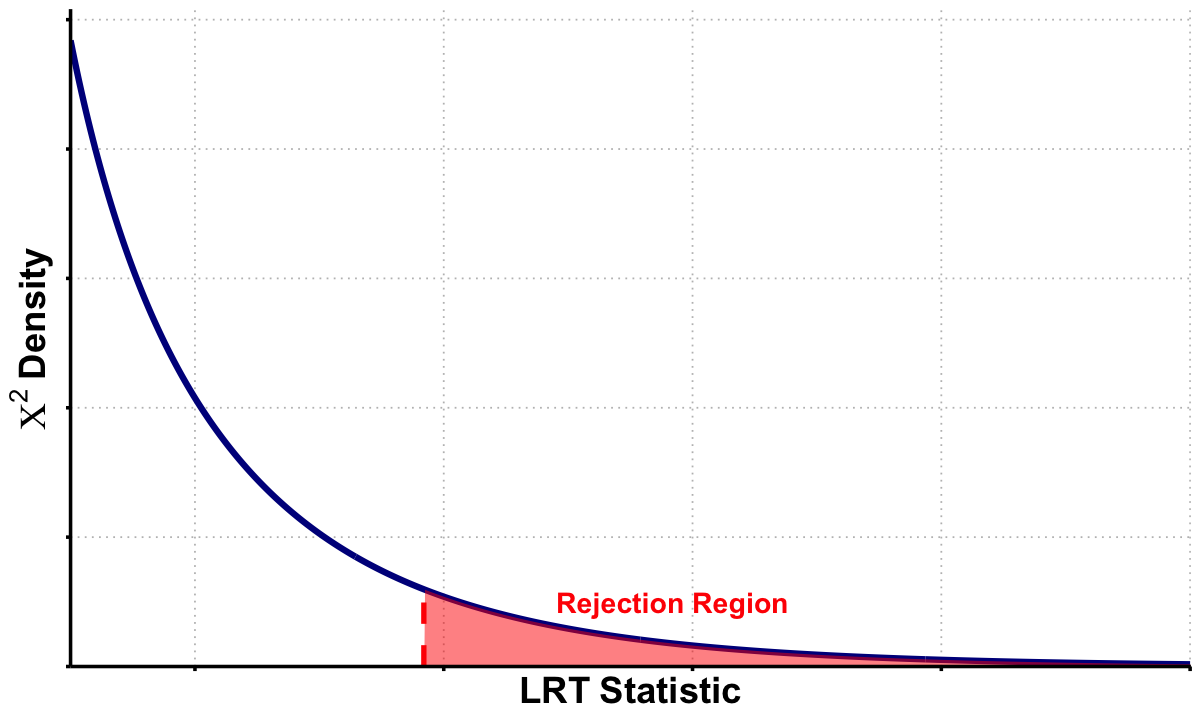

In [13]:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 6)

# Parameters
df <- 1
x_vals <- seq(1, 10, length = 500)
chi_vals <- dchisq(x_vals, df = df)
x_obs <- 3.84  # example observed test statistic

# Data frames
df_chi <- data.frame(x = x_vals, density = chi_vals)
df_reject <- subset(df_chi, x >= x_obs)

# Plot
p_lrt <- ggplot(df_chi, aes(x = x, y = density)) +
  geom_line(color = "darkblue", linewidth = 1.8) +
  geom_area(data = df_reject, aes(x = x, y = density),
            fill = "red", alpha = 0.5) +
  annotate("segment", x = x_obs, xend = x_obs, y = 0, yend = dchisq(x_obs, df),
           color = "red", linetype = "dashed", linewidth = 1.5) +
  annotate("text", x = x_obs + 2, y = 0.025,
           label = "Rejection Region", 
           color = "red", size = 6, fontface = "bold") +
  labs(x = expression(bold(LRT~Statistic)), 
       y = expression(bold(Chi^2~Density))) +
  scale_x_continuous(breaks = seq(0, 10, 2), expand = c(0, 0)) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.05))) +
  theme_minimal() +
  theme(
    text = element_text(size = 14, face = "bold"),
    plot.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_text(size = 22, face = "bold"),
    axis.title.y = element_text(size = 22, face = "bold"),
    panel.grid.major = element_line(color = "gray", linetype = "dotted"),
    panel.grid.minor = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(linewidth = 1),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

# Display and save
print(p_lrt)

ggsave("./cartoons/LRT.png", plot = p_lrt, 
       width = 10, height = 6, 
       bg = "transparent", 
       dpi = 300)
